In [13]:
# Create dataset YAML configuration
import yaml

dataset_config = {
    'path': r'C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2',
    'train': 'train',
    'val': 'val',
    'test': 'test',
    'names': {
        0: 'OK',
        1: 'Defect',
    }
}

with open('metal_casting.yaml', 'w') as f:
    yaml.dump(dataset_config, f)

In [14]:
#Analyze the number of images per class per dataset folder

import os

def count_images_per_class(folder_paths):
    """
    Count the number of images per class in train, val, and test folders
    Args:
        folder_paths (dict): {'train': path, 'val': path, 'test': path}
    Returns:
        dict: Number of images per class per folder
    """
    image_counts = {}
    for folder, folder_path in folder_paths.items():
        image_counts[folder] = {}
        # Loop through each class folder
        for class_name in os.listdir(folder_path):
            class_path = os.path.join(folder_path, class_name)
            if os.path.isdir(class_path):  # Ensure it's a directory
                # Count images in the class folder
                image_files = [f for f in os.listdir(class_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
                image_counts[folder][class_name] = len(image_files)
    return image_counts

base_path = dataset_config['path']
train_path = os.path.join(base_path, dataset_config['train'])
val_path = os.path.join(base_path, dataset_config['val'])
test_path = os.path.join(base_path, dataset_config['test'])

# Configuration
dataset_dirs = {
    'train': train_path,
    'val': val_path,
    'test': test_path
}

classes = list(dataset_config['names'].values())

class_image_counts  = count_images_per_class(dataset_dirs)

# Print results
print("Number of images per class per split:")
for folder, class_counts in class_image_counts.items():
    print(f"\n{folder}:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} images")


Number of images per class per split:

train:
  Defect: 2966 images
  OK: 2184 images

val:
  Defect: 616 images
  OK: 476 images

test:
  Defect: 629 images
  OK: 477 images


In [21]:
import os
import cv2
import pandas as pd
from glob import glob
from tabulate import tabulate

def validate_image_dimensions(image_folder, expected_resolution=None, expected_aspect=None):
    """
    Validates that all images in a folder have consistent resolutions and aspect ratios.
    
    Args:
        image_folder (str): Path to folder containing images
        expected_resolution (tuple): Optional (width, height) to enforce
        expected_aspect (float): Optional aspect ratio (width/height) to enforce
    
    Returns:
        DataFrame: Validation results
    """
    image_paths = glob(os.path.join(image_folder, '*.jpeg'))  # Handles .jpg/.png
    
    results = []
    inconsistent_res = 0
    inconsistent_asp = 0
    
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            continue
            
        h, w = img.shape[:2]
        aspect = w / h
        
        # Check against expected values if provided
        res_valid = (not expected_resolution) or (w == expected_resolution[0] and h == expected_resolution[1])
        asp_valid = (not expected_aspect) or (abs(aspect - expected_aspect) < 0.01)  # Allow 1% tolerance
        
        if not res_valid:
            inconsistent_res += 1
        if not asp_valid:
            inconsistent_asp += 1
            
        results.append({
            'filename': os.path.basename(img_path),
            'width': w,
            'height': h,
            'aspect_ratio': round(aspect, 4),
            'resolution_valid': res_valid,
            'aspect_valid': asp_valid
        })
    
    # Generate summary statistics
    df = pd.DataFrame(results)
    print(f"\nTotal images processed: {len(df)}")
    unique_res = df[['width', 'height']].drop_duplicates()
    unique_asp = df['aspect_ratio'].unique()
    
    print("\n=== Validation Summary ===")
    print(f"Total images checked: {len(df)}")
    print(f"Inconsistent resolutions: {inconsistent_res}")
    print(f"Inconsistent aspect ratios: {inconsistent_asp}\n")
    
    print("=== Unique Resolutions ===")
    print(tabulate(unique_res, headers='keys', showindex=False))
    
    print("\n=== Unique Aspect Ratios ===")
    print(tabulate(pd.DataFrame(unique_asp, columns=['aspect_ratio']), 
          headers='keys', showindex=False))
    
    return df

# Example usage (customize for your needs)
df_results = validate_image_dimensions(
    image_folder=r'C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\*\*',
    expected_resolution=(300, 300),  # Optional: Enforce specific resolution
    expected_aspect=1.0                # Optional: Enforce square aspect (1.0)
)


Total images processed: 7348

=== Validation Summary ===
Total images checked: 7348
Inconsistent resolutions: 0
Inconsistent aspect ratios: 0

=== Unique Resolutions ===
  width    height
-------  --------
    300       300

=== Unique Aspect Ratios ===
  aspect_ratio
--------------
             1


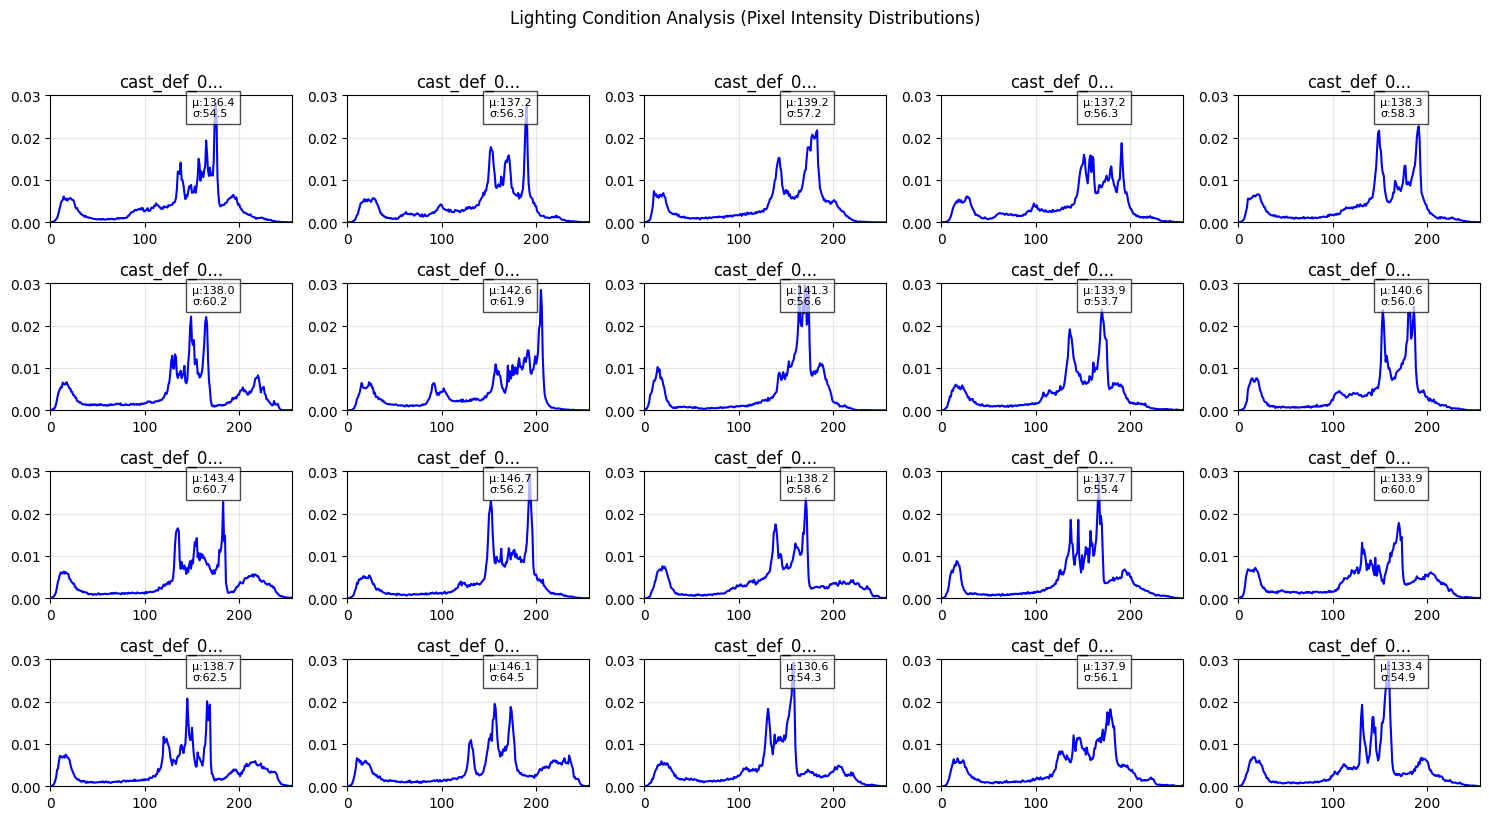


Overall Lighting Statistics (n=20 images):
Mean intensity: 138.6 (0=black, 255=white)
Standard deviation: 57.9 (higher = more contrast)
Median intensity: 153.0
5th/95th percentile: 17.0/212.0


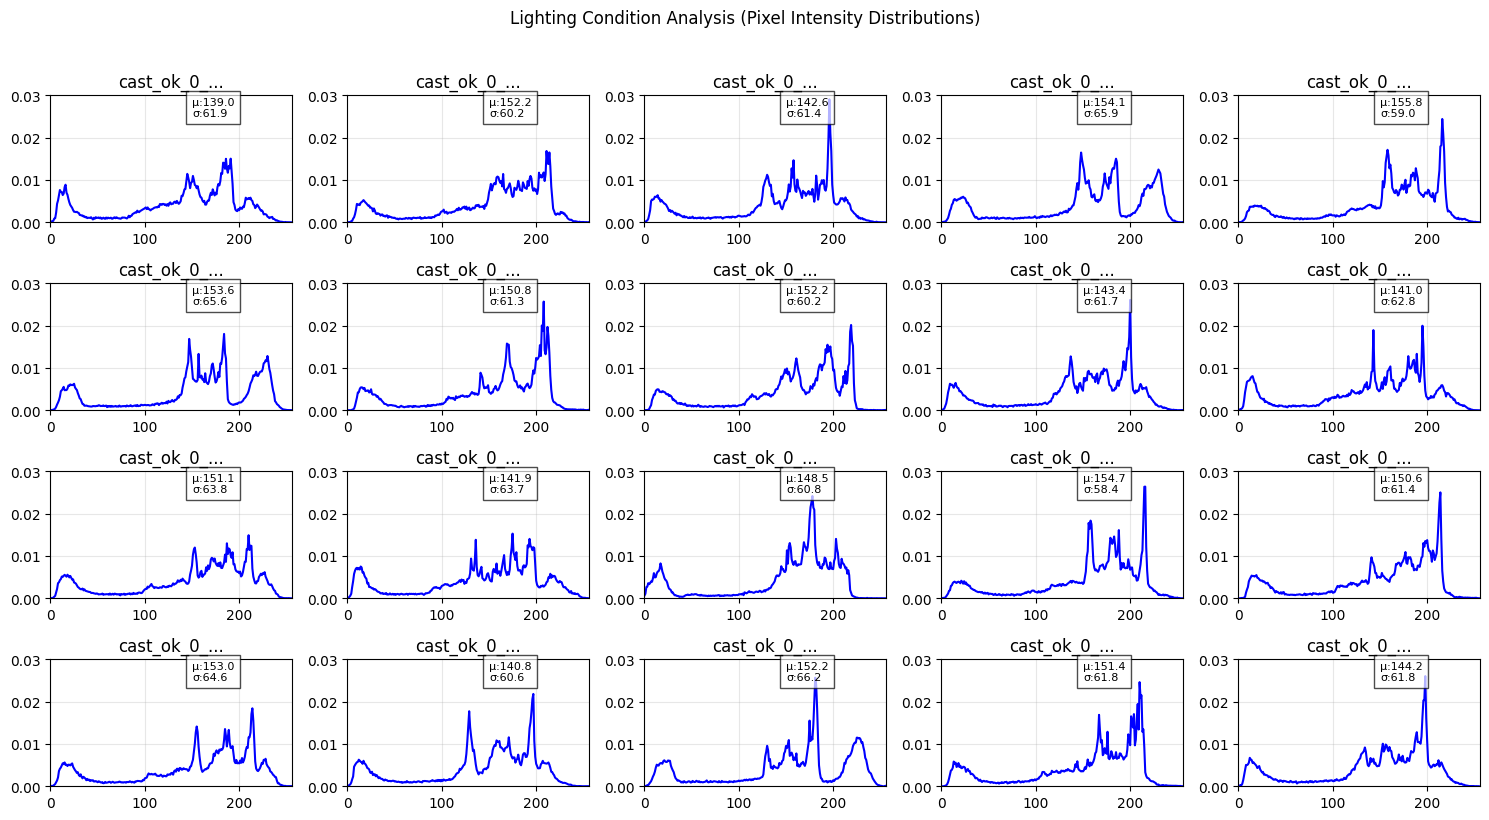


Overall Lighting Statistics (n=20 images):
Mean intensity: 148.6 (0=black, 255=white)
Standard deviation: 62.4 (higher = more contrast)
Median intensity: 165.0
5th/95th percentile: 16.0/221.0


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import os

def plot_lighting_conditions(image_folder, sample_size=20):
    """
    Analyze lighting conditions across a dataset of casting product images.
    
    Args:
        image_folder (str): Path to folder containing inspection images
        sample_size (int): Number of images to sample for visualization
    """
    # Get list of images
    image_paths = glob(os.path.join(image_folder, '*.jpeg'))[:sample_size]  # Adjust extension as needed
    
    # Set up plot
    plt.figure(figsize=(15, 8))
    plt.suptitle('Lighting Condition Analysis (Pixel Intensity Distributions)', y=1.02)
    
    for i, img_path in enumerate(image_paths):
        # Read image in grayscale
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        # Calculate histogram
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        hist = hist / hist.sum()  # Normalize
        
        # Plot individual image histogram
        plt.subplot(4, 5, i+1)  # Adjust grid size based on sample_size
        plt.plot(hist, color='blue')
        plt.title(os.path.basename(img_path)[:10] + "...")
        plt.xlim([0, 256])
        plt.ylim([0, 0.03])  # Adjust based on your data
        plt.grid(True, alpha=0.3)
        
        # Annotate key metrics
        mean_val = np.mean(img)
        std_val = np.std(img)
        plt.text(150, 0.025, f"μ:{mean_val:.1f}\nσ:{std_val:.1f}", 
                fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

    plt.tight_layout()
    plt.show()
    
    # Generate combined statistics
    all_pixels = []
    for img_path in image_paths:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        all_pixels.extend(img.flatten())
    
    print(f"\nOverall Lighting Statistics (n={len(image_paths)} images):")
    print(f"Mean intensity: {np.mean(all_pixels):.1f} (0=black, 255=white)")
    print(f"Standard deviation: {np.std(all_pixels):.1f} (higher = more contrast)")
    print(f"Median intensity: {np.median(all_pixels):.1f}")
    print(f"5th/95th percentile: {np.percentile(all_pixels, 5):.1f}/{np.percentile(all_pixels, 95):.1f}")

# Usage example
plot_lighting_conditions(r'C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test\Defect', sample_size=20)
plot_lighting_conditions(r'C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test\OK', sample_size=20)

In [1]:
# Pre-requite to run the training. Follow the following steps for Torch setup
# 1. Make sure you have a Nvidia GPU to support CUDA
# 2. Install the Torch based on the guideline from https://pytorch.org/get-started/locally/
# 3. Run the following to validate the CUDA, Torch and Torchvision version

import torch, torchvision

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")


PyTorch version: 2.7.0+cu126
Torchvision version: 0.22.0+cu126
CUDA available: True
CUDA version: 12.6


In [16]:
#Yolo model training

from ultralytics import YOLO

# Initialize model
model = YOLO('yolo11n-cls.pt')

# Start training
results = model.train(
    data=r'C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2',
    epochs=100,
    imgsz=224,
    batch=32,
    optimizer='Adam',
    seed=42,
    device='0',  # '0' for GPU, 'cpu' for CPU
    name='yolov11n_classifier'
)

New https://pypi.org/project/ultralytics/8.3.92 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.85  Python-3.11.9 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
engine\trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2, epochs=100, time=None, patience=100, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov11n_classifier6, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False

train: Scanning C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\train... 5150 images, 0 corrupt: 100%|██████████| 5150/5150 [00:02<00:00, 2013.02it/s]


train: New cache created: C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\train.cache


val: Scanning C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\val... 1092 images, 0 corrupt: 100%|██████████| 1092/1092 [00:00<00:00, 1434.80it/s]


val: New cache created: C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\val.cache
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs\classify\yolov11n_classifier6
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100     0.438G     0.3545         30        224: 100%|██████████| 161/161 [00:06<00:00, 23.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.10it/s]

                   all      0.611          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100     0.414G     0.4038         30        224: 100%|██████████| 161/161 [00:05<00:00, 27.09it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.35it/s]

                   all      0.658          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100     0.426G     0.3248         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.39it/s]

                   all      0.564          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100     0.426G     0.5088         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 89.57it/s]

                   all      0.808          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100     0.426G     0.4042         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 87.31it/s]

                   all      0.834          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100     0.426G     0.3398         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.22it/s]

                   all      0.756          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100     0.426G     0.2884         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.08it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 92.83it/s] 

                   all      0.732          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100     0.426G     0.2502         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.03it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100     0.426G       0.19         30        224: 100%|██████████| 161/161 [00:04<00:00, 33.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 87.85it/s]

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100     0.426G     0.1971         30        224: 100%|██████████| 161/161 [00:04<00:00, 33.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 79.92it/s]

                   all      0.846          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100     0.426G     0.2087         30        224: 100%|██████████| 161/161 [00:05<00:00, 29.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 74.52it/s]

                   all      0.801          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100     0.426G     0.1807         30        224: 100%|██████████| 161/161 [00:05<00:00, 29.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.55it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100     0.426G     0.1733         30        224: 100%|██████████| 161/161 [00:05<00:00, 32.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.53it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100     0.426G     0.2091         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 88.52it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100     0.426G     0.1736         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 88.26it/s]

                   all      0.926          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100     0.426G     0.1822         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 92.40it/s]

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100     0.426G     0.1796         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.30it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 88.78it/s]

                   all      0.742          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100     0.426G     0.1487         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 81.83it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100     0.426G     0.1909         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.82it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 82.78it/s]

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100     0.426G     0.1885         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 88.03it/s]

                   all      0.961          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100     0.426G     0.1647         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.63it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 81.99it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100     0.428G     0.2836         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 94.11it/s]

                   all      0.755          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100     0.426G     0.2471         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 88.51it/s]

                   all      0.966          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100     0.426G     0.1448         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.97it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.77it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100     0.426G     0.1535         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 92.96it/s]

                   all      0.567          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100     0.428G     0.2545         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 89.84it/s]

                   all      0.233          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100     0.426G     0.2587         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 88.20it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100     0.426G      0.164         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.49it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100     0.426G     0.1747         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 79.46it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100     0.426G     0.1395         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 92.60it/s]

                   all      0.842          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100     0.426G     0.1284         30        224: 100%|██████████| 161/161 [00:04<00:00, 32.23it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 92.53it/s]

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100     0.426G     0.1341         30        224: 100%|██████████| 161/161 [00:04<00:00, 32.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 84.95it/s]

                   all      0.961          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100     0.426G     0.1437         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 67.53it/s]

                   all      0.969          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100     0.426G     0.1158         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 64.62it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100     0.426G     0.1126         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.88it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100     0.426G     0.1049         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.35it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.55it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100     0.426G     0.1176         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.36it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 84.68it/s]

                   all      0.907          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100     0.428G     0.1199         30        224: 100%|██████████| 161/161 [00:05<00:00, 32.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 92.33it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100     0.426G      0.136         30        224: 100%|██████████| 161/161 [00:04<00:00, 32.92it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.21it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100     0.426G     0.1283         30        224: 100%|██████████| 161/161 [00:04<00:00, 33.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.47it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100     0.426G     0.1093         30        224: 100%|██████████| 161/161 [00:04<00:00, 33.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.18it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100     0.426G     0.1216         30        224: 100%|██████████| 161/161 [00:04<00:00, 32.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.08it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100     0.426G    0.09772         30        224: 100%|██████████| 161/161 [00:04<00:00, 33.01it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 93.72it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100     0.426G     0.1316         30        224: 100%|██████████| 161/161 [00:04<00:00, 32.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 87.25it/s]

                   all      0.821          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100     0.426G     0.1295         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.12it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100     0.426G     0.1245         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 84.61it/s]

                   all      0.971          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100     0.426G     0.1244         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.40it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.97it/s]

                   all      0.974          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100     0.428G     0.1146         30        224: 100%|██████████| 161/161 [00:05<00:00, 29.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 82.16it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100     0.426G     0.1036         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.37it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100     0.426G     0.1011         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 87.03it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100     0.426G    0.09781         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.03it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100     0.426G    0.09805         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 92.37it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100     0.426G    0.09445         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 84.57it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100     0.426G    0.08954         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 89.27it/s]

                   all      0.994          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100     0.426G     0.1007         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.79it/s]

                   all      0.767          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100     0.426G     0.1063         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.38it/s]

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100     0.426G    0.09545         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.46it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.39it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100     0.426G    0.08832         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.59it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100     0.426G    0.09497         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.13it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 81.79it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100     0.426G    0.08938         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.19it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100     0.426G     0.0929         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 77.31it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100     0.426G    0.08344         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.43it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.40it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100     0.426G    0.08652         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.43it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100     0.426G    0.08019         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.72it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.95it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100     0.426G    0.08297         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.79it/s]

                   all      0.982          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100     0.426G    0.08206         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.44it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.82it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100     0.426G    0.06784         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 87.23it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100     0.426G    0.07837         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.18it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.63it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100     0.426G     0.0812         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.82it/s]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100     0.426G    0.08365         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 62.82it/s]


                   all      0.995          1

      Epoch    GPU_mem       loss  Instances       Size


     71/100     0.426G    0.07344         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 81.00it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     72/100     0.426G    0.07831         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 82.77it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100     0.426G    0.08001         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 81.32it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100     0.426G    0.06919         30        224: 100%|██████████| 161/161 [00:04<00:00, 32.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.57it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100     0.426G    0.07785         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 84.76it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100     0.426G    0.07867         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.02it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     77/100     0.426G    0.07451         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 75.30it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


     78/100     0.426G    0.05771         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 87.65it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     79/100     0.426G    0.05476         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 89.02it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     80/100     0.426G     0.0664         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.54it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 89.80it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100     0.426G    0.05694         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.22it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     82/100     0.428G    0.05318         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.96it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 87.77it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     83/100     0.426G    0.05961         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.17it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.70it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100     0.426G    0.05887         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 87.11it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     85/100     0.426G    0.06165         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.76it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     86/100     0.426G    0.05695         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.29it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 90.36it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     87/100     0.426G    0.05943         30        224: 100%|██████████| 161/161 [00:05<00:00, 32.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 86.02it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     88/100     0.426G    0.05518         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 92.77it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     89/100     0.426G    0.05072         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.83it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     90/100     0.426G    0.05556         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.59it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     91/100     0.426G    0.04375         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.11it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 81.84it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     92/100     0.426G    0.04993         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.27it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 89.53it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     93/100     0.426G    0.04779         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.41it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     94/100     0.426G    0.04852         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.86it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 91.62it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     95/100     0.426G    0.04362         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.12it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 80.94it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100     0.428G    0.03715         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 85.84it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     97/100     0.426G    0.03885         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.98it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 75.39it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     98/100     0.426G    0.03487         30        224: 100%|██████████| 161/161 [00:05<00:00, 30.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 75.44it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


     99/100     0.426G    0.03406         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.28it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 75.57it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


    100/100     0.426G    0.03066         30        224: 100%|██████████| 161/161 [00:05<00:00, 31.05it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 93.64it/s]

                   all      0.996          1



100 epochs completed in 0.164 hours.
Optimizer stripped from runs\classify\yolov11n_classifier6\weights\last.pt, 3.2MB
Optimizer stripped from runs\classify\yolov11n_classifier6\weights\best.pt, 3.2MB

Validating runs\classify\yolov11n_classifier6\weights\best.pt...
Ultralytics 8.3.85  Python-3.11.9 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
train: C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\train... found 5150 images in 2 classes  
val: C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\val... found 1092 images in 2 classes  
test: C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test... found 1106 images in 2 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:00<00:00, 77.18it/s]


                   all      0.996          1
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\yolov11n_classifier6


In [17]:
# Validate the model
metrics = model.val(data='metal_casting.yaml', split = 'test')  


Ultralytics 8.3.85  Python-3.11.9 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
YOLO11n-cls summary (fused): 47 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs


test: Scanning C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test... 1106 images, 0 corrupt: 100%|██████████| 1106/1106 [00:00<00:00, 1455.78it/s]


test: New cache created: C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test.cache


               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:00<00:00, 70.92it/s]


                   all      0.998          1
Speed: 0.0ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\yolov11n_classifier62


In [18]:
metrics

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001EC80999D90>
curves: []
curves_results: []
fitness: 0.9990958273410797
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9981916546821594, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9990958273410797}
save_dir: WindowsPath('runs/classify/yolov11n_classifier62')
speed: {'preprocess': 0.029185352706776472, 'inference': 0.2953415008381373, 'loss': 0.00020054239101007336, 'postprocess': 0.0002992765832301667}
task: 'classify'
top1: 0.9981916546821594
top5: 1.0

In [20]:
#Run inference

from ultralytics import YOLO

# Model Path
model_path = r'C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\runs\classify\yolov11n_classifier6\weights\best.pt'

# Load a pretrained YOLO11n model
model = YOLO(model_path)

sample_image_path = r'C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test\Defect\cast_def_0_1*.jpeg'

# Run inference on 'bus.jpg' with arguments
result = model.predict(sample_image_path, save = True, show_conf = True)

# View results
for r in result:
    print(r.to_df())  


image 1/299 C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test\Defect\cast_def_0_1059.jpeg: 224x224 Defect 1.00, OK 0.00, 4.4ms
image 2/299 C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test\Defect\cast_def_0_1063.jpeg: 224x224 Defect 1.00, OK 0.00, 5.4ms
image 3/299 C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test\Defect\cast_def_0_108.jpeg: 224x224 Defect 1.00, OK 0.00, 6.9ms
image 4/299 C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test\Defect\cast_def_0_1096.jpeg: 224x224 Defect 1.00, OK 0.00, 7.6ms
image 5/299 C:\Users\User\OneDrive\Documents\Programming\metal_cast_detection\notebooks\model_training\datasets\metal_casting_2\test\Defect\cast_def_0_112.jpeg: 224x224 Defect 1.00, OK 0.00, 13.3ms
image 6/29